## Prepare

In [ ]:
#coutils package
!pip install git+https://github.com/Mooozer/starterCode_-fromJohnson
import coutils
from coutils import fix_random_seed

  Cloning https://github.com/Mooozer/starterCode_-fromJohnson to /tmp/pip-req-build-o3pjwjbo
  Running command git clone -q https://github.com/Mooozer/starterCode_-fromJohnson /tmp/pip-req-build-o3pjwjbo
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-py3-none-any.whl size=10307 sha256=38ef1d3cdf0513e80ecb04c2bf8cc0bb1768ad60661ad7af708265a5e0016e8e
  Stored in directory: /tmp/pip-ephem-wheel-cache-x8hpyi_7/wheels/26/bc/a7/8262fb80fdb4423f53fd1042948b03aae3f09d1a69b16f3ec5
Successfully built Colab-Utils


In [ ]:
import numpy as np
import pandas as pd
from collections import OrderedDict
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import seaborn as sn

if torch.cuda.is_available:
  print('Good to go!')
else:
  print('Please set GPU via Edit -> Notebook Settings.')

Good to go!


In [ ]:
# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

## Load Data

In [ ]:
rrdata = pd.read_csv('rrdata.csv')
data = pd.read_csv('merged_sur_hrv_hr.csv')
onehot_time = pd.get_dummies(data.time_of_day, prefix='OneHot')
data = data.drop(['time_of_day'], axis=1 )
data = pd.concat([onehot_time, data],axis=1) 

In [ ]:
data1 = data[['OneHot_day', 'OneHot_evening','OneHot_morning','OneHot_night','bpm', 'meanrr', 'mxdmn', 'sdnn',
       'rmssd', 'pnn50', 'mode', 'amo', 'lf', 'hf', 'vlf', 'lfhf',
       'total_power', 'day_after_test', 'S_COVID_BREATH', 'S_COVID_CONFUSION',
       'S_COVID_COUGH', 'S_COVID_FATIGUE', 'S_COVID_FEVER', 'S_COVID_PAIN',
       'S_COVID_BLUISH', 'class4']] 

In [ ]:
from scipy.stats import iqr

N, T, C= 1480, 100, 4

##Point Features:
rr_features = pd.DataFrame({'rr_var' : []}) 
#Variance: the average of the squared differences from the mean
rr_features['rr_var'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).var(axis=1)
#Skewness, a measure of symmetry:
rr_features['rr_skew'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).skew(axis=1)
#Kurtosis: How heavily the tails of a distribution differ from the tails of a normal distribution:
rr_features['rr_kurt'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).kurtosis(axis=1)
#Max: 
rr_features['rr_max'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).max(axis=1)
#Min: 
rr_features['rr_min'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).min(axis=1)
#Median:
rr_features['rr_median'] = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).median(axis=1)
#Interquartile range (IQR):  the difference between the 75th and 25th percentile of the data.
rr_features['rr_IQR'] = iqr(rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1),axis=1)

ori_point_features = data1.drop(['class4'], axis=1) #original point features
Pointdata = torch.tensor(pd.concat([ori_point_features, rr_features],axis=1).values).to(torch.float) #(1480, 25)
Pointdata = (Pointdata-Pointdata.min(0, keepdim=True).values)/(Pointdata.max(0, keepdim=True).values - Pointdata.min(0, keepdim=True).values) #Rescale 


##Sequence Features:  
#rr_diff: Difference
rr_diff = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1).diff(periods=-1, axis=1)*(-1) 
rr_diff['rr99'] = 1/3*(rr_diff['rr98'] + rr_diff['rr97'] + rr_diff['rr96'])
rr_diff_tensor = torch.tensor(rr_diff.values).to(torch.float)
rr_diff_tensor = (rr_diff_tensor-rr_diff_tensor.min(0, keepdim=True).values)/(rr_diff_tensor.max(0, keepdim=True).values - rr_diff_tensor.min(0, keepdim=True).values) #Rescale 
rr_diff_tensor = rr_diff_tensor.reshape(N,T,1)
#rr_AbsMeanDiff = Absolute Different from the mean:
rr_AbsMeanDiff = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1)
rr_AbsMeanDiff = abs(rr_AbsMeanDiff-rr_AbsMeanDiff.mean(0).values)
rr_AbsMeanDiff_tensor = torch.tensor(rr_AbsMeanDiff.values).to(torch.float)
rr_AbsMeanDiff_tensor = (rr_AbsMeanDiff_tensor-rr_AbsMeanDiff_tensor.min(0, keepdim=True).values)/(rr_AbsMeanDiff_tensor.max(0, keepdim=True).values - rr_AbsMeanDiff_tensor.min(0, keepdim=True).values) #Rescale 
rr_AbsMeanDiff_tensor = rr_AbsMeanDiff_tensor.reshape(N,T,1)
#Original seq features
rr = rrdata.drop(['user_code','time_of_day','S_COVID_OVERALL','day_after_test'],axis=1) #original seq features
rr_tensor = torch.tensor(rr.values).to(torch.float)
rr_tensor = (rr_tensor-rr_tensor.min(0, keepdim=True).values)/(rr_tensor.max(0, keepdim=True).values - rr_tensor.min(0, keepdim=True).values) #Rescale 
rr_tensor = rr_tensor.reshape(N,T,1)
#Combine
Seqdata = torch.cat((rr_tensor, rr_diff_tensor, rr_AbsMeanDiff_tensor), 2) #(1480, 100, 2)


##Class label:  
class_y = torch.tensor(data1['class4'].values)  #(N=1480, )

print("Pointdata:", Pointdata.shape, Pointdata.dtype)
print("Seqdata:", Seqdata.shape, Seqdata.dtype)
print("class_y:", class_y.shape, class_y.dtype)


In [ ]:
from sklearn.model_selection import train_test_split
indices = list(ori_point_features.index)
Pointdata_train, Pointdata_test, Seqdata_train, Seqdata_test, class_y_train, class_y_test ,indices_train ,indices_test = train_test_split(Pointdata, 
                                                                                                                                          Seqdata, 
                                                                                                                                          class_y, 
                                                                                                                                          indices, 
                                                                                                                                          test_size=0.2, 
                                                                                                                                          random_state=6)
Pointdata_train, Pointdata_test = Pointdata_train.to(torch.float), Pointdata_test.to(torch.float)
Seqdata_train, Seqdata_test = Seqdata_train.to(torch.float), Seqdata_test.to(torch.float)

## Uncertainty quantification of the model

In [ ]:
def RNN_DNN_test_UQ(self, Pointdata, Seqdata):
      """
      Inputs:
      - Pointdata: (N, V) 
      - Seqdata: (N, T, D)

      Outputs:
      - scalar: classficition 
      """

      Pointdata = Pointdata.to(self.device)  #(N,V)
      Seqdata = Seqdata.to(self.device)

      #(1) h0
      A0 = Seqdata[:,0,:].mm(self.Wx) #(N,4H)
      h0 =  A0[:,0:self.H] + A0[:,self.H:2*self.H] + A0[:,2*self.H:3*self.H] + A0[:,3*self.H:4*self.H]

      #(2) multi-state(hidden state)
      if self.cell_type == 'lstm':
        hidden_state = lstm_forward(Seqdata, h0, self.Wx, self.Wh, self.b, self.T)   #(N,T,H=1) 
      
      N = Pointdata.shape[0]
      H = self.H 
      T = self.T
      
      #(3) single state 
      single_state = hidden_state.reshape(N, T*H).mm(self.W_proj)+self.b_proj  #(N,P)  

      #(4) DNN 
      DNNInput = torch.cat((Pointdata, single_state), 1)  #(N, V+P)
      DNNhidden = DNNInput.mm(self.W_d1)+self.b_d1  
      DNNhidden = torch.sigmoid(DNNhidden)
      for i in range(2,len(self.DNN_hidden_Size)+1):
        DNNhidden = DNNhidden.mm(eval('self.W_d'+str(i))) + eval('self.b_d'+str(i))
        DNNhidden = F.leaky_relu(DNNhidden, negative_slope=0.01)  
      DNNoutput = DNNhidden.mm(eval('self.W_d'+str(len(self.DNN_hidden_Size)+1))) + eval('self.b_d'+str(len(self.DNN_hidden_Size)+1))  

      #(5)
      pred_y = DNNoutput.argmax(dim=1)
      pred_y_prob = F.softmax(DNNoutput, dim=1)
      return pred_y, pred_y_prob

RNN_DNN.UQ_test_process = RNN_DNN_test_UQ


In [ ]:
#bootstrap sample
import random
train_size = 1184
B=10*20 
probB = torch.empty(1, 296, 4)  #initialize probability training set 
probB_train = torch.empty(1, 1184, 4)  #initialize probability test set

for b in range(B):
  print('------------------------- Bootstrip %s ------------------------'%(b) )
  index_b = random.choices(range(Pointdata_train.shape[0]) , k=Pointdata_train.shape[0])
  Pointdata_train_b = Pointdata_train[index_b]
  Seqdata_train_b = Seqdata_train[index_b]
  class_y_train_b = class_y_train[index_b]

  num_epochs = 1400
  batch_size = train_size 
  learning_rate = 1e-3
  rnn_dnn_model_UQ = RNN_DNN( 
            cell_type='lstm',
            input_dim = 3,     #Seqdata_train.shape[2]
            input_dim_v = 32,  #Pointdata_train.shape[1],
            input_dim_t= 20,   #Seqdata_train.shape[1], 
            proj_dim = 5,
            C=4, 
            hidden_dim = 1, 
            reg = 0.0, 
            dropratio = 0.3, 
            DNN_hidden_Size=[1024, 1024, 2048, 1024, 1024], 
            **to_float_cuda)

  print('learning rate is: ', learning_rate)
  ModelTrain(rnn_dnn_model_UQ, Pointdata_train_b, Seqdata_train_b, class_y_train_b,
                  num_epochs=num_epochs, batch_size=batch_size,
                  learning_rate=learning_rate)

  rnn_dnn_model_UQ = rnn_dnn_model_UQ.eval()  
  y_pred_train_b, y_pred_prob_train_b = rnn_dnn_model_UQ.UQ_test_process(Pointdata_train_b, Seqdata_train_b)
  y_pred_train_b, y_pred_prob_train_b = y_pred_train_b.to('cpu'), y_pred_prob_train_b.to('cpu')
  y_pred_b, y_pred_prob_b = rnn_dnn_model_UQ.UQ_test_process(Pointdata_test, Seqdata_test)
  y_pred_b, y_pred_prob_b = y_pred_b.to('cpu'), y_pred_prob_b.to('cpu')

  probB = torch.cat([probB, y_pred_prob_b.data.reshape(1,296,4)], dim = 0)
  probB_train = torch.cat([probB_train, y_pred_prob_train_b.data.reshape(1,1184,4)], dim=0)

probB = probB[1:,:,:]  # remove the initialized prob
probB_train = probB_train[1:,:,:] # remove the initialized prob

In [ ]:
probB_all = torch.load('BSProb.pt')

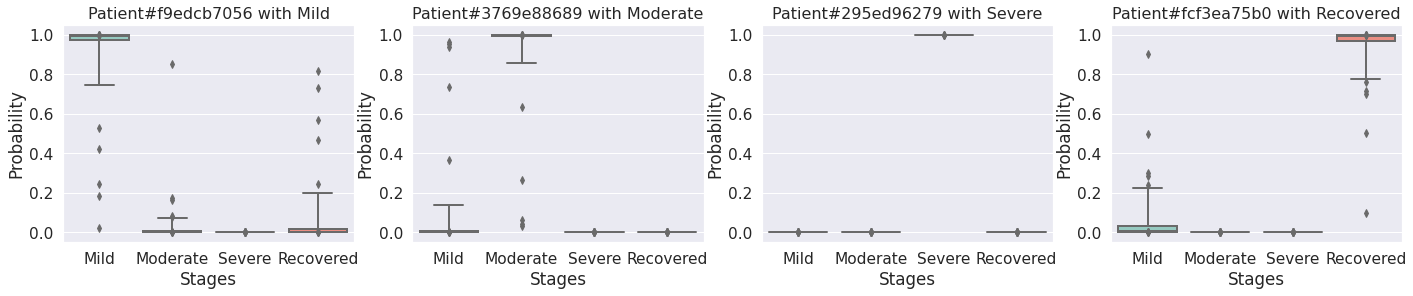

In [ ]:
import seaborn as sn
import random
random.seed(6)
stageCode= ['Mild','Moderate','Severe','Recovered']
fig=plt.figure(figsize=(24,4))
columns = 4
rows = 1
indexs = [251,110,29,182]
patientCode = rrdata.loc[indices_test].iloc[indexs]['user_code'].tolist()

for i in range(4):
  #index = (class_y_test == i).nonzero().reshape(-1).tolist()
  #indexi = random.choice(index)
  indexi = indexs[i]
  codei = patientCode[i]
  pd_probB = pd.DataFrame(probB_all[:,indexi,:].reshape(-1,4).numpy())
  pd_probB = pd_probB.rename(columns={0: "Mild", 1: "Moderate", 2:"Severe", 3:"Recovered"})
  pd_probB = pd_probB.melt(var_name="Stages", value_name="Probability")
 
  fig.add_subplot(rows, columns, i+1)
  ax = sn.boxplot(x="Stages", y="Probability", data=pd_probB, whis=[2.5, 97.5], linewidth=2,  palette="Set3")
  plt.title('Patient#%s with %s'%(codei, stageCode[i]), fontsize=16)
  plt.ylabel("Probability") 
plt.show()


## Permutation Feature Importance for each class (time-consuming)



### full model

In [ ]:
num_epochs = 1400
batch_size = 1184 

# create the RNN_DNN model
rnn_dnn_model = RNN_DNN(
          cell_type='lstm',
          input_dim = 3,  #3,     #Seqdata_train.shape[2],  
          input_dim_v = 32, #32,  #Pointdata_train.shape[1], if only consider LSTM, then, 0 
          input_dim_t= 20, #20,   #Seqdata_train.shape[1], 
          proj_dim = 0, #5,   #if only consider DNN, then, 0 
          C=4, 
          hidden_dim = 1, 
          reg = 0.0, 
          dropratio = 0.3, 
          #DNN_hidden_Size=[256, 1024, 2048, 1024, 512],  #str11
          DNN_hidden_Size=[1024, 1024, 2048, 1024, 1024], 
          **to_float_cuda)

for learning_rate in [1e-3]:
  print('learning rate is: ', learning_rate)
  ModelTrain(rnn_dnn_model, Pointdata_train, Seqdata_train, class_y_train,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)

In [ ]:
rnn_dnn_model = rnn_dnn_model.eval()  
y_pred_train, loss_train = rnn_dnn_model.test_process(Pointdata_train, Seqdata_train, class_y_train )
y_pred_train, loss_trainfull = y_pred_train.to('cpu') , loss_train.item()

y_pred, loss_test= rnn_dnn_model.test_process(Pointdata_test, Seqdata_test, class_y_test)
y_pred, loss_testfull = y_pred.to('cpu'), loss_test.item()
y_pred

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score
from tensorflow.keras.utils import to_categorical
auc_score4full = roc_auc_score(to_categorical(class_y_test), to_categorical(y_pred), multi_class="ovo", average=None)
auc0full,auc1full,auc2full,auc3full = auc_score4full[0], auc_score4full[1], auc_score4full[2], auc_score4full[3], 
reportfull =  classification_report(class_y_test, y_pred, output_dict=True )
f1_0full,f1_1full,f1_2full,f1_3full = reportfull['0']['f1-score'],reportfull['1']['f1-score'],reportfull['2']['f1-score'],reportfull['3']['f1-score']
pre0full,pre1full,pre2full,pre3full = reportfull['0']['precision'],reportfull['1']['precision'],reportfull['2']['precision'],reportfull['3']['precision']

### Feature Importance for each class

In [ ]:
pointFeatures = pd.concat([ori_point_features, rr_features],axis=1).columns
seqFeatures = ['rr','rr_diff','rr_AbsMeanDiff'] 
FeaImpResult4 = pd.DataFrame({'auc0' : [], 'auc1' : [], 'auc2': [],'auc3' : [], 
                             'f1_0' : [], 'f1_1' : [], 'f1_2': [], 'f1_3': [],
                             'pre_0':[],  'pre_1':[], 'pre_2':[], 'pre_3':[],}) 

In [ ]:
# For Point data 
from sklearn.metrics import roc_auc_score
from keras.utils import to_categorical

for i in range(len(pointFeatures)):
  print('------------------------- Permutation Variable %s ------------------------'%(pointFeatures[i]) )
  num_epochs = 1400
  batch_size = 1184 
  learning_rate = 1e-3
  # create the RNN_DNN model
  rnn_dnn_model_FI = RNN_DNN(
            cell_type='lstm',
            input_dim = 3,     #Seqdata_train.shape[2]
            input_dim_v = 32-1,  #Pointdata_train.shape[1],
            input_dim_t= 20,   #Seqdata_train.shape[1], 
            proj_dim = 5,
            C=4, 
            hidden_dim = 1, 
            reg = 0.0, 
            dropratio = 0.3, 
            DNN_hidden_Size=[1024, 1024, 2048, 1024, 1024], 
            **to_float_cuda)

  Pointdata_train_permu = torch.cat([Pointdata_train[:, 0:i], Pointdata_train[:, (i+1):]],dim=1)
  Pointdata_test_permu = torch.cat([Pointdata_test[:, 0:i], Pointdata_test[:, (i+1):]],dim=1)

  ModelTrain(rnn_dnn_model_FI, Pointdata_train_permu, Seqdata_train, class_y_train,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)
                
  rnn_dnn_model_FI = rnn_dnn_model_FI.eval()  
  y_pred_train, loss_traini = rnn_dnn_model_FI.test_process(Pointdata_train_permu, Seqdata_train, class_y_train)
  y_pred_train, loss_traini = y_pred_train.to('cpu'), loss_traini.item()
  y_pred, loss_testi= rnn_dnn_model_FI.test_process(Pointdata_test_permu, Seqdata_test, class_y_test)
  y_pred, loss_testi= y_pred.to('cpu'), loss_testi.item()
  
  auc4 =  roc_auc_score(to_categorical(class_y_test), to_categorical(y_pred), multi_class="ovo", average=None)
  report =  classification_report(class_y_test, y_pred, output_dict=True )
  f1_0,f1_1,f1_2,f1_3 = report['0']['f1-score'],report['1']['f1-score'],report['2']['f1-score'],report['3']['f1-score']
  pre_0,pre_1,pre_2,pre_3 = report['0']['precision'],report['1']['precision'],report['2']['precision'],report['3']['precision']
  FeaImpResult4.loc[pointFeatures[i]] = [auc4[0],auc4[1],auc4[2],auc4[3], f1_0,f1_1,f1_2,f1_3, pre_0,pre_1,pre_2,pre_3]

# For sequence data
for i in range(len(seqFeatures)):
  print('------------------------- Permutation Variable %s ------------------------'%(seqFeatures[i]) )
  num_epochs = 1400
  batch_size = 1184 
  learning_rate = 1e-3
  # create the RNN_DNN model
  rnn_dnn_model_FI = RNN_DNN(
            cell_type='lstm',
            input_dim = 3-1,     #Seqdata_train.shape[2]
            input_dim_v = 32,  #Pointdata_train.shape[1],
            input_dim_t= 20,   #Seqdata_train.shape[1], 
            proj_dim = 5,
            C=4, 
            hidden_dim = 1, 
            reg = 0.0, 
            dropratio = 0.3, 
            DNN_hidden_Size=[1024, 1024, 2048, 1024, 1024], 
            **to_float_cuda)
  Seqdata_train_permu = torch.cat([Seqdata_train[:, :, 0:i], Seqdata_train[:,:, (i+1):]],dim=2)
  Seqdata_test_permu = torch.cat([Seqdata_test[:, :, 0:i], Seqdata_test[:,:, (i+1):]],dim=2)

  ModelTrain(rnn_dnn_model_FI, Pointdata_train, Seqdata_train_permu, class_y_train,
                num_epochs=num_epochs, batch_size=batch_size,
                learning_rate=learning_rate)
  
  rnn_dnn_model_FI = rnn_dnn_model_FI.eval()  
  y_pred_train, loss_traini = rnn_dnn_model_FI.test_process(Pointdata_train, Seqdata_train_permu, class_y_train)
  y_pred_train, loss_traini = y_pred_train.to('cpu'), loss_traini.item()
  y_pred, loss_testi= rnn_dnn_model_FI.test_process(Pointdata_test, Seqdata_test_permu, class_y_test)
  y_pred, loss_testi= y_pred.to('cpu'), loss_testi.item()  
  
  auc4 =  roc_auc_score(to_categorical(class_y_test), to_categorical(y_pred), multi_class="ovo", average=None)
  report =  classification_report(class_y_test, y_pred, output_dict=True )
  f1_0,f1_1,f1_2,f1_3 = report['0']['f1-score'],report['1']['f1-score'],report['2']['f1-score'],report['3']['f1-score']
  pre_0,pre_1,pre_2,pre_3 = report['0']['precision'],report['1']['precision'],report['2']['precision'],report['3']['precision']
  FeaImpResult4.loc[seqFeatures[i]] = [auc4[0],auc4[1],auc4[2],auc4[3], f1_0,f1_1,f1_2,f1_3, pre_0,pre_1,pre_2,pre_3]
  
torch.save(FeaImpResult4, 'FeaImpResult4.pt')

In [ ]:
#add full-data model's result
FeaImpResult4.loc['FullData'] = [auc0full, auc1full, auc2full, auc3full,f1_0full,f1_1full,f1_2full,f1_3full,pre0full,pre1full,pre2full,pre3full ]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Plot 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import plotly.express as px

In [ ]:
result=pd.read_csv(r"/content/FeaImpResult4.csv")
result = result.drop([0,1,2,3,18,19,20,21,22,23,24])
result_auc=result.iloc[:, 1:5]
FI = result_auc.iloc[-1] - result_auc
FI = FI.drop([32])

In [ ]:
titlename = ['Mild','Moderate','Severe','Recovery']
for i in range(4):
  FI_temp=FI.iloc[:,i]-FI.iloc[:,i].min()
  FI_trans=FI_temp/FI_temp.max()

  d = {'Factors':result.iloc[:,0][:-1],'FI':FI_trans}
  df = pd.DataFrame(d)
  df = df.sort_values(by='FI', ascending=0)
  fig = px.bar_polar(df, r="FI", theta="Factors",
                    color="Factors", template="seaborn", 
                    color_discrete_sequence= px.colors.sequential.Plasma_r)
  fig.update_layout(title=titlename[i] )
  fig.show()